In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [2]:
# read in cleaned data
df = gp.read_file('data/cb_dist/cb_dist.shp')
df.cb = df.cb.astype('int')
cb_rides = pd.read_csv('data/cb_rides.csv')
demo = pd.read_csv('data/demo.csv')

In [3]:
# merge distance and number of rides tables
df = df.merge(cb_rides, left_on = 'cb', right_on = 'BCTCB2010', )

In [4]:
# create a geoid at the census block group level
df['geoid'] = [str(i)[0:12] for i in df.cb ]

In [5]:
# dissolve to the block group level
df = df.dissolve(by = 'geoid', as_index = False)
df.geoid = df.geoid.astype('int')

In [6]:
# merge in the demographics data
df = df.merge(demo, on = 'geoid')

In [7]:
# combine no vehicle units into one column

df['no_vehicle'] = df['no_vehicle_own'] + df['no_vehicle_rent']

df.head()

,geoid,geometry,cb,dist_avg,BCTCB2010,n_rides,pop,bike,commute_time,income_pc,no_vehicle_rent,no_vehicle_own,no_vehicle
0,360610002021,"POLYGON ((988718.24560547 199114.4710203864, 9...",360610002021004,2.518680,360610002021004,13185,345,0,107,16017.0,89,29,118
1,360610006002,"POLYGON ((987096.1130371091 198401.6248289843,...",360610006002002,1.885837,360610006002002,10520,2532,0,1001,14986.0,762,0,762
2,360610006005,"POLYGON ((987737.7452392566 198484.652599982, ...",360610006005001,2.181730,360610006005001,12891,2111,0,652,11777.0,662,0,662
3,360610007001,"POLYGON ((982182.0942382803 196935.6336180423,...",360610007001002,2.487477,360610007001002,17031,6294,16,4652,101041.0,2615,423,3038
4,360610009001,"POLYGON ((981040.2952270519 195769.9566160961,...",360610009001026,2.790164,360610009001026,10086,613,0,423,92940.0,165,19,184


### Develop a simple model first

In [8]:
# regress number of rides on average commute distance
lm = smf.ols('n_rides ~ dist_avg', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.546
Date:                Mon, 05 Dec 2016   Prob (F-statistic):            0.00675
Time:                        12:19:48   Log-Likelihood:                -1688.4
No. Observations:                 153   AIC:                             3381.
Df Residuals:                     151   BIC:                             3387.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.232e+04   4438.353      9.536      0.000      3.36e+04  5.11e+04
dist_avg   -7640.5866   2781.448     -2.747      0.007     -1.31e+04 -2145.004
==============================================================================
Omnibus:                       52.619   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.437
Skew:                           1.467   Prob(JB):                     1.57e-27
Kurtosis:                       6.280   Cond. No.                         7.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Look at a more extensive model

In [9]:
lm2 = smf.ols('n_rides ~ dist_avg + pop + bike + income_pc + commute_time + no_vehicle', data = df).fit()

lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3.908
Date:                Mon, 05 Dec 2016   Prob (F-statistic):            0.00119
Time:                        12:19:48   Log-Likelihood:                -1680.7
No. Observations:                 153   AIC:                             3375.
Df Residuals:                     146   BIC:                             3397.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     3.945e+04   5720.751      6.896      0.000      2.81e+04  5.08e+04
dist_avg     -7769.3327   3060.398     -2.539      0.012     -1.38e+04 -1720.928
pop             -2.8524      3.383     -0.843      0.401        -9.539     3.834
bike            14.4561     57.172      0.253      0.801       -98.535   127.448
income_pc        0.0391      0.031      1.279      0.203        -0.021     0.100
commute_time    16.7192      6.464      2.586      0.011         3.943    29.495
no_vehicle     -16.3592      8.835     -1.852      0.066       -33.821     1.102
==============================================================================
Omnibus:                       48.010   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.421
Skew:                           1.348   Prob(JB):                     2.86e-24
Kurtosis:                       6.121   Cond. No.                     4.92e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
df.corr()

,geoid,cb,dist_avg,BCTCB2010,n_rides,pop,bike,commute_time,income_pc,no_vehicle_rent,no_vehicle_own,no_vehicle
geoid,1.000000,1.000000,-0.284176,1.000000,0.214149,-0.166535,-0.118305,-0.005887,0.187215,-0.059228,0.048850,-0.041729
cb,1.000000,1.000000,-0.284176,1.000000,0.214149,-0.166535,-0.118305,-0.005887,0.187215,-0.059228,0.048850,-0.041729
dist_avg,-0.284176,-0.284176,1.000000,-0.284176,-0.218162,0.388264,0.078983,0.240024,-0.131623,0.190125,-0.047720,0.173574
BCTCB2010,1.000000,1.000000,-0.284176,1.000000,0.214149,-0.166535,-0.118305,-0.005887,0.187215,-0.059228,0.048850,-0.041729
n_rides,0.214149,0.214149,-0.218162,0.214149,1.000000,-0.051078,-0.040184,0.092164,0.246092,-0.028252,0.069650,-0.003071
pop,-0.166535,-0.166535,0.388264,-0.166535,-0.051078,1.000000,0.202884,0.856741,-0.122131,0.777432,0.145663,0.833532
bike,-0.118305,-0.118305,0.078983,-0.118305,-0.040184,0.202884,1.000000,0.120468,-0.142822,0.172204,0.024637,0.181860
commute_time,-0.005887,-0.005887,0.240024,-0.005887,0.092164,0.856741,0.120468,1.000000,0.132250,0.809981,0.229755,0.896758
income_pc,0.187215,0.187215,-0.131623,0.187215,0.246092,-0.122131,-0.142822,0.132250,1.000000,-0.190437,0.456613,-0.025372
no_vehicle_rent,-0.059228,-0.059228,0.190125,-0.059228,-0.028252,0.777432,0.172204,0.809981,-0.190437,1.000000,-0.192149,0.934316


### Another model following simple feature selection

In [11]:
lm2 = smf.ols('n_rides ~ dist_avg + commute_time + no_vehicle + income_pc', data = df).fit()

lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     5.726
Date:                Mon, 05 Dec 2016   Prob (F-statistic):           0.000259
Time:                        12:19:48   Log-Likelihood:                -1681.1
No. Observations:                 153   AIC:                             3372.
Df Residuals:                     148   BIC:                             3387.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     3.916e+04   5673.727      6.902      0.000      2.79e+04  5.04e+04
dist_avg     -8679.3876   2838.782     -3.057      0.003     -1.43e+04 -3069.606
commute_time    13.8558      5.506      2.516      0.013         2.975    24.736
no_vehicle     -17.7905      8.517     -2.089      0.038       -34.622    -0.959
income_pc        0.0476      0.028      1.675      0.096        -0.009     0.104
==============================================================================
Omnibus:                       45.366   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.069
Skew:                           1.304   Prob(JB):                     1.38e-21
Kurtosis:                       5.876   Cond. No.                     4.91e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

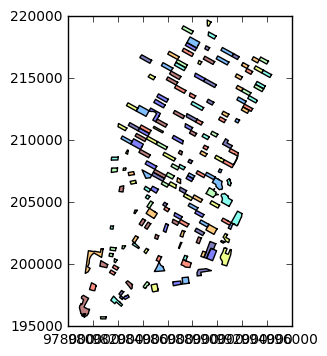

In [12]:
df.plot()